<a href="https://colab.research.google.com/github/drew-walkerr/DetectingBias/blob/main/detecting_bias_neural_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Links from class
1. https://www.kaggle.com/deshwalmahesh/nlp-beginner-1-rnn-lstm-gru-embeddings-glove
2. https://www.kaggle.com/kredy10/simple-lstm-for-text-classification 

3. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


In [6]:
# This is a BoW classifier to detect the presence of provider scare quotes in provider clinical notes

import pandas as pd
import numpy
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import feature_selection
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gensim
from gensim.models import Word2Vec
tfds.disable_progress_bar()

SEED = 42



In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Set up Word2Vec

In [4]:
# Load in data
gold_standard = pd.read_csv("gold_standard_bias_annotation_doc_training.csv")


Mini HW 9/10—Neural classifier —Instructions:
Due 10 Dec
In this two part HW, you will split your dataset into training/test sets, and then build a neu-
ral classifier of your choice. Recommend LSTM but for an extra challenge you can also consider a transformer/RoBERTA if you prefer (esp if you are working with a low resource language). Do this homework in python only. You will need to move to google co-lab if you haven’t already and take
advantage of a GPU.

1. First, for HW 8, set up your neural model. You will likely want to use the same training/test split
as before, but if you make any adjustments make sure to note the reason. You will need to include
Glove embeddings as a feature of your LSTM model. Consider the many available tutorials such
as this or this. Consider at least two specifications of your neural model, and write up what you
did and why.





In [23]:
# Split
seed = 1234
X = gold_standard['Sentence']
y = gold_standard['quote_use']
#Hyperparameters
max_features_model = 3000
splits = 5
#Splitting and model
skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle= True)
for train_index, test_index in skf.split(X, y):
    sentences_train, sentences_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

sentences_train = np.asarray(sentences_train)
y_train = np.asarray(y_train)
sentences_test = np.asarray(sentences_test)
y_test = np.asarray(y_test)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')


In [ ]:
#class Word2Vec(tf.keras.Model):
#  def __init__(self, vocab_size, embedding_dim):
#   super(Word2Vec, self).__init__()
#    self.target_embedding = layers.Embedding(vocab_size,
#                                      embedding_dim,
#                                      input_length=1,
#                                      name="w2v_embedding")
#    self.context_embedding = layers.Embedding(vocab_size,
#                                       embedding_dim,
#                                       input_length=num_ns+1)
#
# def call(self, pair):
#    target, context = pair
#    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
#    # context: (batch, context)
#    if len(target.shape) == 2:
#      target = tf.squeeze(target, axis=1)
#    # target: (batch,)
#    word_emb = self.target_embedding(target)
#    # word_emb: (batch, embed)
#    context_emb = self.context_embedding(context)
#    # context_emb: (batch, context, embed)
#    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
#    return dots

In [50]:
#embedding_dim = 50
#embedding_matrix = create_embedding_matrix(model,tokenizer.word_index, embedding_dim)


TypeError: ignored

In [75]:
from keras.models import Sequential
from keras import layers
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
maxlen = 200
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 50)           190250    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 190,771
Trainable params: 190,771
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.1880
Testing Accuracy:  0.1880


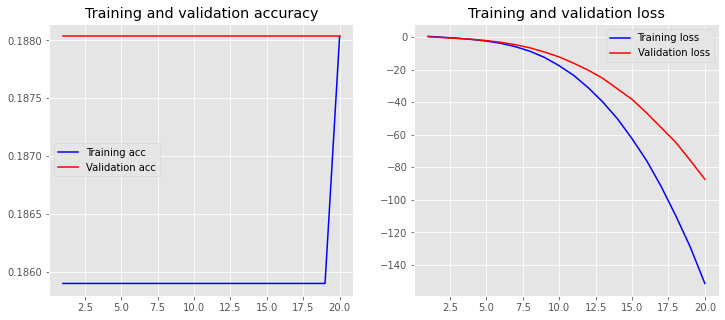

In [77]:
plot_history(history)

In [78]:
model.evaluate(X_train,y_train)

15/15 [==============================] - 0s 22ms/step - loss: -163.6583 - accuracy: 0.1880


[-163.6583251953125, 0.18803419172763824]

In [80]:
# predict crisp classes for test set
yhat_classes = model.output(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

TypeError: ignored

2. Next, for HW 10, estimate the F1 score and plot a precision/recall curve to compare your neural
model specifications to your BOW model in the same plot. Consider using a tutorial (e.g. here).
Write up in overleaf what you did and why, and include the plot that compares your neural and
BOW models in your write up on overleaf and submit on Canvas.
